# Agrupamento
Objetivo: Gerar modelos que agrupem dados com características extraídas de partes de músicas. Depois, avaliá-los de forma extrínseca (usando o atributo das classes). Por fim, avaliar ocorrência de similaridade entre estilos musicais diferentes.

Em um primeiro momento, vamos carregar os dados:

In [5]:
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Mineração de Dados/trabalho4_dados_Luciana.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Depois tratá-los:

Número de instâncias antes: 9648
Número de instâncias depois: 6216
All values are equal in column 'length'


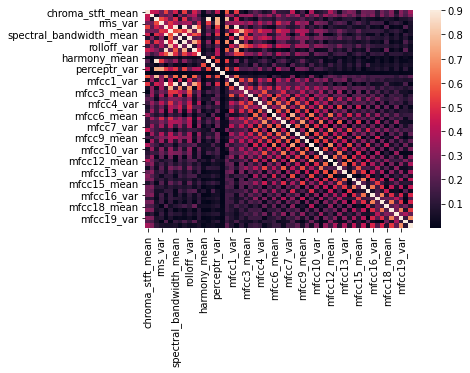

In [6]:
# removendo linhas duplicadas
print('Número de instâncias antes: ' + str(len(df)))
df.drop_duplicates(inplace=True)
print('Número de instâncias depois: ' + str(len(df)))

# verificação da coluna com valores iguais
if (df['length'] == df['length'][0]).all():
    print("All values are equal in column 'length'")
    df.drop('length', axis=1, inplace=True)
else:
    print("All values are not equal  in column 'length'")

le = LabelEncoder()

classes_str = df['label'].values
classes = le.fit_transform(df['label'])

# removendo colunas que não precisamos
df.drop('filename', axis=1, inplace=True)
df.drop('label', axis=1, inplace=True)

# analisando correlação entre atributos para remoção de redundância
corr_matrix = df.corr().abs()

sns.heatmap(corr_matrix, vmax=0.9)

# seleciono o triângulo superior da matriz
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# guardo os nomes dos atributos com alta correlação (> 0.9)
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# tiro as colunas com alta correlação
df.drop(to_drop, axis=1, inplace=True)

all_lines = df.values

Os dois algoritmos de agrupamento que serão utilizados são K-Means e DBSCAN.

Normalização:

In [7]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
all_lines = scaler.fit_transform(all_lines)

#K-MEANS

Usando o método de Elbow, vamos determinar o número de clusters.

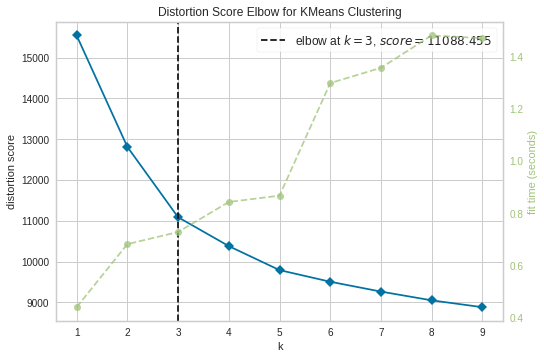

In [8]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(all_lines) # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Com o valor k = 3 para o número de clusters, vamos gerar o modelo:

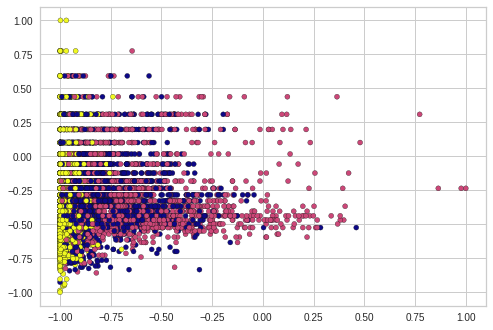

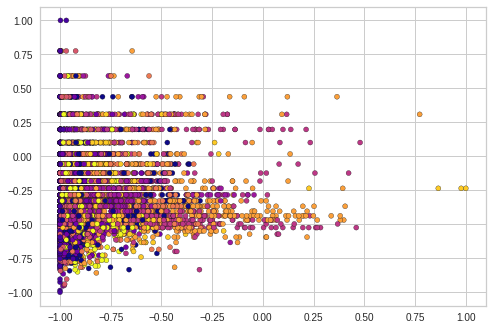

In [9]:
from sklearn.cluster import MiniBatchKMeans
mbkmeans = MiniBatchKMeans(n_clusters=3, batch_size=10)
y_mbkmeans = mbkmeans.fit_predict(all_lines)

plt.scatter(all_lines[:, 14], all_lines[:, 15], marker="o", c=y_mbkmeans, s=25, edgecolor="k", cmap='plasma')
plt.show()
plt.scatter(all_lines[:, 14], all_lines[:, 15], marker="o", c=classes, s=25, edgecolor="k", cmap='plasma')
plt.show()

#DBSCAN

{0, 1, 2, -1}


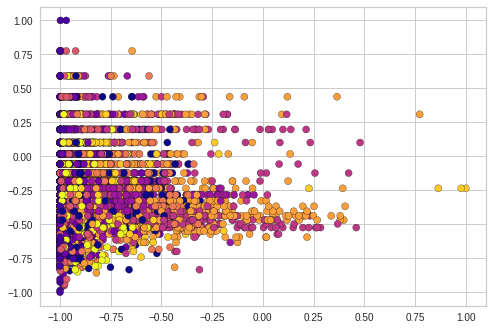

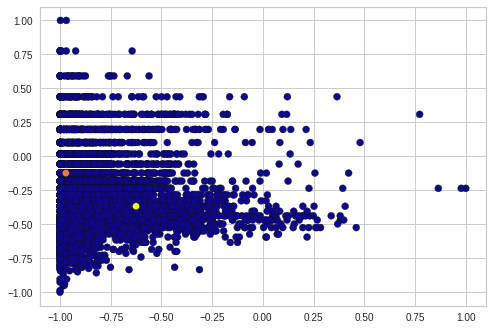

In [10]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=0.3, min_samples=5)

y_dbscan = model.fit_predict(all_lines)

labels_dbscan = set(y_dbscan)
print(labels_dbscan)

plt.scatter(all_lines[:, 14], all_lines[:, 15], marker="o", c=classes, edgecolor="k", cmap='plasma')
plt.show()

plt.scatter(all_lines[:, 14], all_lines[:, 15], marker="o", c=y_dbscan, edgecolor="k", cmap='plasma')
plt.show()

Vamos usar Medida-V (uma média harmônica entre homogeneidade e completude), Indíce Aleatório Ajustado e Coeficiente da Silhueta para medir a qualidade dos agrupamentos.

K-Means

In [11]:
from sklearn import metrics

ari_kmeans = metrics.adjusted_rand_score(classes, y_mbkmeans)
print("Resultado KMeans: %f"%(ari_kmeans))

v_measure_kmeans = metrics.homogeneity_completeness_v_measure(classes, y_mbkmeans)
print("Resultado KMeans: H=%f, C=%f, V=%f"%(v_measure_kmeans))

ss_kmeans = metrics.silhouette_score(all_lines, y_mbkmeans, metric="euclidean")
print("Resultado KMeans: %f"%(ss_kmeans))

Resultado KMeans: 0.140303
Resultado KMeans: H=0.185998, C=0.391378, V=0.252159
Resultado KMeans: 0.183011


DBSCAN

In [12]:
from sklearn import metrics

ari_dbscan = metrics.adjusted_rand_score(classes, y_dbscan)
print("Resultado DBSCAN: %f"%(ari_dbscan))

v_measure_dbscan = metrics.homogeneity_completeness_v_measure(classes, y_dbscan)
print("Resultado DBSCAN: H=%f, C=%f, V=%f"%(v_measure_dbscan))

ss_dbscan = metrics.silhouette_score(all_lines, y_dbscan, metric="euclidean")
print("Resultado DBSCAN: %f"%(ss_dbscan))

Resultado DBSCAN: 0.000002
Resultado DBSCAN: H=0.002893, C=0.290011, V=0.005730
Resultado DBSCAN: -0.160204


##Ocorrência de similaridade entre estilos musicais distintos nos trechos


Dicionário com os estilos



In [13]:
print(classes)
print(classes_str)

map_styles = {}
for i in range(len(classes_str)):
  map_styles[str(classes[i])] = classes_str[i]

map_styles

[6 1 9 ... 7 0 9]
['metal' 'classical' 'rock' ... 'pop' 'blues' 'rock']


{'0': 'blues',
 '1': 'classical',
 '2': 'country',
 '3': 'disco',
 '4': 'hiphop',
 '5': 'jazz',
 '6': 'metal',
 '7': 'pop',
 '8': 'reggae',
 '9': 'rock'}

Olhando para os resultados do K-Means:



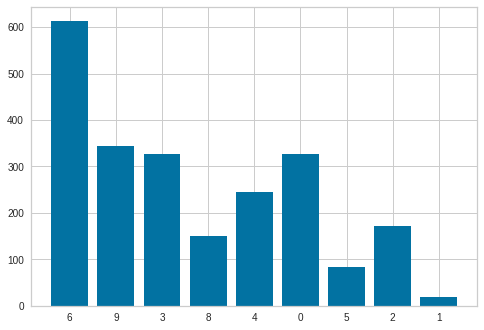

In [14]:
from collections import Counter

estilo_0 = []
estilo_1 = []
estilo_2 = []

for i in range(len(classes)):
  if y_mbkmeans[i] == 0:
    estilo_0.append(classes[i])
  elif y_mbkmeans[i] == 1:
    estilo_1.append(classes[i])
  elif y_mbkmeans[i] == 2:
    estilo_2.append(classes[i]) 


ocurrences_0 = Counter(estilo_0)
ocurrences_1 = Counter(estilo_1)
ocurrences_2 = Counter(estilo_2)

names_0 = list(ocurrences_0.keys())
values_0 = list(ocurrences_0.values())

plt.bar(range(len(ocurrences_0)), values_0, tick_label=names_0)
plt.show()

Metal, Rock, Disco e Blues aparecem com mais frequência nesse grupo.

Destaque para um grande número de Metal e um pequeno número de Clássica.

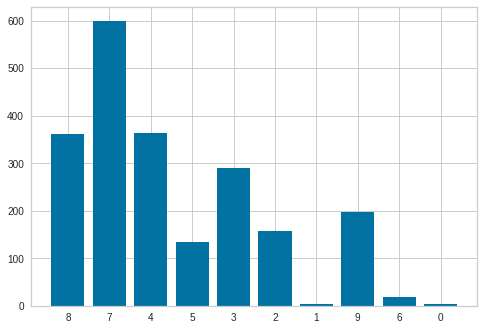

In [15]:
names_1 = list(ocurrences_1.keys())
values_1 = list(ocurrences_1.values())

plt.bar(range(len(ocurrences_1)), values_1, tick_label=names_1)
plt.show()

Mais frequentes: Pop, Reggae, HipHop e Disco.

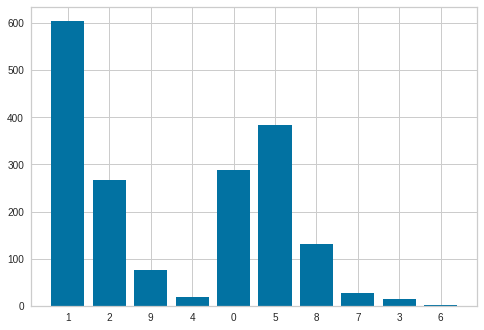

In [16]:
names_2 = list(ocurrences_2.keys())
values_2 = list(ocurrences_2.values())

plt.bar(range(len(ocurrences_2)), values_2, tick_label=names_2)
plt.show()

Mais frequentes: Blues, Jazz, Clássica e Country.
Destaque para um grande número de Clássica e um pequeno número de Metal.